In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client

### Define CESM case

In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['CaCO3_FLUX_IN'] 

### Get CaCO3 flux in

In [3]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       
    files = sorted(glob(f'{path}/{case}.pop.h.ecosys.nyear1.{v}.0249-0310.nc'))

    print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
CaCO3_FLUX_IN
['/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/tseries/year_1/cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.ecosys.nyear1.CaCO3_FLUX_IN.0249-0310.nc']
CPU times: user 55.9 ms, sys: 14.6 ms, total: 70.5 ms
Wall time: 309 ms


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### get potential density

In [5]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['PD']

In [6]:
%%time

ds_list = []

print(f'reading {case}')

ds_mon = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds_mon = xr.merge((ds_mon, dsv))
    ds_list.append(ds_mon)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
PD
CPU times: user 61.7 ms, sys: 7.72 ms, total: 69.4 ms
Wall time: 202 ms


In [7]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_mon = ds_mon.drop([v for v in ds_mon.variables if v not in keep_vars])

In [8]:
ds_ann_pd = ds_mon.mean(dim='time')
ds_ann_pd

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    PD           (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

In [9]:
cesm_ann_ds=ds.mean(dim='time')

In [10]:
cesm_ann_ds['PD']=ds_ann_pd['PD']

### compute sigma densities

In [11]:
cesm_ann_ds['sigma'] = cesm_ann_ds.PD * 1000. - 1000.

### Now DS has everything we need

In [12]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:        (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    CaCO3_FLUX_IN  (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    PD             (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    sigma          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

In [13]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [14]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA * 0.0001
depths=ds_woa.z_t * 0.01
dz=cesm_ann_ds.dz * 0.01

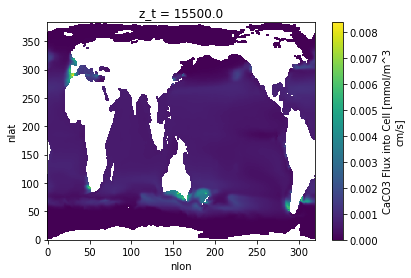

In [15]:
cesm_ann_ds.CaCO3_FLUX_IN.isel(z_t=15).plot()

In [16]:
sigma_surf=cesm_ann_ds['sigma'].isel(z_t=0)

In [17]:
GCB_CaCO3_flux_in = cesm_ann_ds.CaCO3_FLUX_IN.where(sigma_surf<27.0).where(sigma_surf>26.0).where(cesm_ann_ds.TLAT<0.)

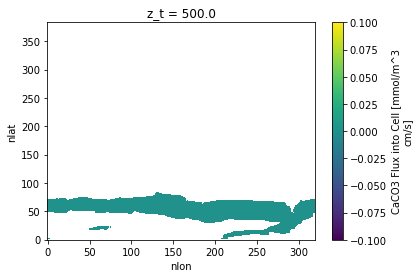

In [18]:
GCB_CaCO3_flux_in.isel(z_t=0).plot()

In [19]:
GCB_CaCO3_flux_in_profile =  esmlab.weighted_mean(GCB_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()

In [20]:
GCB_CaCO3_flux_in_profile_SD =  esmlab.weighted_std(GCB_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()

In [21]:
GCB_CaCO3_flux_in_profile_SD.values

array([0.        , 0.00020679, 0.00040027, 0.00052251, 0.00061337,
       0.00065314, 0.00066687, 0.00066611, 0.0006565 , 0.00064783,
       0.00063655, 0.0006271 , 0.00061726, 0.00060946, 0.00060267,
       0.00059758, 0.0005884 , 0.00058403, 0.0005798 , 0.00057565,
       0.0005716 , 0.00056762, 0.00056366, 0.00055927, 0.00055515,
       0.00054843, 0.00054391, 0.00053908, 0.00053391, 0.00052839,
       0.0005225 , 0.00051624, 0.00050953, 0.00050243, 0.00049439,
       0.00048487, 0.00047458, 0.00046306, 0.00044997, 0.0004356 ,
       0.00041969, 0.00040217, 0.00038246, 0.00036292, 0.00034321,
       0.00032327, 0.00030319, 0.00028431, 0.00026501, 0.00024611,
       0.00023076, 0.00021876, 0.00020778, 0.00019798, 0.00019245,
       0.00018818, 0.00018786, 0.00019353, 0.00021589, 0.00026176])

In [22]:
GCB_CaCO3_flux_in_profile.values

array([0.        , 0.00016463, 0.00032181, 0.00044966, 0.00053946,
       0.0005894 , 0.00061129, 0.00061612, 0.00061235, 0.00060574,
       0.00059676, 0.00058825, 0.00058126, 0.00057512, 0.00057001,
       0.00056558, 0.00056026, 0.00055619, 0.00055247, 0.00054864,
       0.00054502, 0.00054143, 0.00053772, 0.00053396, 0.00053004,
       0.00052536, 0.00052137, 0.000517  , 0.00051221, 0.00050761,
       0.00050214, 0.00049665, 0.00049043, 0.00048439, 0.00047684,
       0.00046778, 0.00045825, 0.00044736, 0.00043511, 0.00042163,
       0.00040656, 0.00038941, 0.00037176, 0.0003527 , 0.00033349,
       0.00031469, 0.00029596, 0.00027787, 0.00026047, 0.00024418,
       0.00022993, 0.00021852, 0.00021198, 0.00020896, 0.00020837,
       0.00021079, 0.0002147 , 0.00021876, 0.00023527, 0.00022899])

In [23]:
GCB_CaCO3_flux_in_profile = GCB_CaCO3_flux_in_profile * 0.01 * 86400 * 365 * 0.001 * 100.09

In [24]:
GCB_CaCO3_flux_in_profile_SD = GCB_CaCO3_flux_in_profile_SD * 0.01 * 86400 * 365 * 0.001 * 100.09

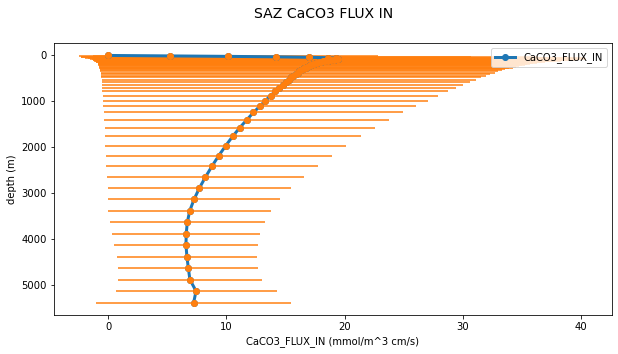

In [25]:
fig = plt.figure(figsize=(10,5))

plt.suptitle('SAZ CaCO3 FLUX IN', fontsize=14)


#COLUMN 1  - ALKs

ax = fig.add_subplot(1,1,1)
ax.plot(GCB_CaCO3_flux_in_profile.values, depths, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
#ax.plot(ds_glb['ALK_glodap'].values, depths, label='ALK_glodap', linewidth=3)
ax.legend()
ax.errorbar(GCB_CaCO3_flux_in_profile.values, depths, xerr=GCB_CaCO3_flux_in_profile_SD.values, fmt='o')
ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (mmol/m^3 cm/s)')
plt.gca().invert_yaxis()


###  once it's good, write out dataset

In [26]:
out = GCB_CaCO3_flux_in_profile.values
filename = "output_data/GCB_CaCO3_flux_in_profile.txt"
np.savetxt(filename,out, delimiter=',')

In [27]:
out = GCB_CaCO3_flux_in_profile_SD.values
filename = "output_data/GCB_CaCO3_flux_in_profile_stdev.txt"
np.savetxt(filename,out, delimiter=',')

In [28]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:        (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    CaCO3_FLUX_IN  (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    PD             (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    sigma          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

In [29]:
#drop PD
cesm_ann_ds = cesm_ann_ds.drop(['PD','sigma'])
#mask dataset
GCB_ann_ds = cesm_ann_ds.CaCO3_FLUX_IN.where(sigma_surf<27.0).where(sigma_surf>26.0).where(cesm_ann_ds.TLAT<0.)

In [31]:
# outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_GCB_CaCO3flux.nc'
# GCB_ann_ds.to_netcdf(outfile)